# Data & AI: Swarm IOT

Oke dus ik ga het hier schetsen en dan kunnen jullie het verder uitwerken en zien hoe jullie het zouden structureren. Als er iets ni duidelijk is gelieve te vragen.

In [79]:
#imports
import pandas as pd
import cv2  as cv
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
import tensorflow as tf
import time 

## Inlezen van csv

In [98]:
#read the csv named complete_swarmIoT_full_labeled_dataset.csv and save it in a dataframe
df = pd.read_csv('complete_swarmIoT_full_labeled_dataset.csv')
df['image'].head()

0    1666698189853.jpg
1    1666698196832.jpg
2    1666698203856.jpg
3    1666698210837.jpg
4    1666698217850.jpg
Name: image, dtype: object

## Inlezen van alle fotos

in de les hebben we dit gezien
er zijn corrupte fotos. Maar dit kan aan mij liggen ik heb 4 keer de zip moeten downloaden omdat de download telkens failde. Er zijn bij mij 4 corrupte fotos.

```python

leuven = plt.imread('data/leuven.jpg')
proximus = plt.imread('data/proximus.jfif')

leuven = cv.resize(leuven, (416, 416))
proximus = cv.resize(proximus, (416, 416))
images = [leuven, proximus]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
ax[0].imshow(leuven)
ax[1].imshow(proximus)

```

Inlezen van images moet aangepast worden dat ze enkel in de lijst gezet worden als de filename in df['image'] voorkomt.
Alvast bedankt aan wie dit ook doet.

X - Jens

In [108]:
path = 'data computer vision assignment\\'
extension = '*jpg'

images = []

for root, dirs, files in os.walk(path):
    for file in glob.glob(os.path.join(root, extension)):
        try:
            image = plt.imread(file)
            image = cv.resize(image, (416, 416))
            images.append(image)

        except:
            print('image corrupted')
            print(file)

image corrupted
data computer vision assignment\3 De nayer (Loop piste)\1666699912159.jpg
image corrupted
data computer vision assignment\3 De nayer (Loop piste)\1666699919158.jpg
image corrupted
data computer vision assignment\3 De nayer (Loop piste)\1666699926156.jpg
image corrupted
data computer vision assignment\3 De nayer (Loop piste)\1666699933158.jpg


In [110]:
images

[array([[[ 36,  39,  48],
         [ 44,  47,  54],
         [ 55,  57,  64],
         ...,
         [ 71,  67,  32],
         [ 80,  77,  46],
         [ 76,  75,  47]],
 
        [[ 39,  42,  51],
         [ 44,  46,  54],
         [ 51,  52,  60],
         ...,
         [ 79,  74,  40],
         [ 78,  75,  45],
         [ 81,  78,  51]],
 
        [[ 41,  43,  52],
         [ 44,  44,  52],
         [ 50,  50,  58],
         ...,
         [101,  96,  63],
         [ 99,  94,  65],
         [100,  95,  70]],
 
        ...,
 
        [[121, 111, 120],
         [121, 111, 120],
         [116, 106, 115],
         ...,
         [176, 164, 165],
         [177, 165, 167],
         [180, 168, 170]],
 
        [[132, 122, 131],
         [133, 123, 132],
         [131, 121, 130],
         ...,
         [188, 176, 178],
         [182, 170, 172],
         [175, 163, 165]],
 
        [[136, 126, 135],
         [137, 127, 136],
         [138, 128, 137],
         ...,
         [188, 176, 178],
  

## Easy task

### Using an existing object detection model from YOLO

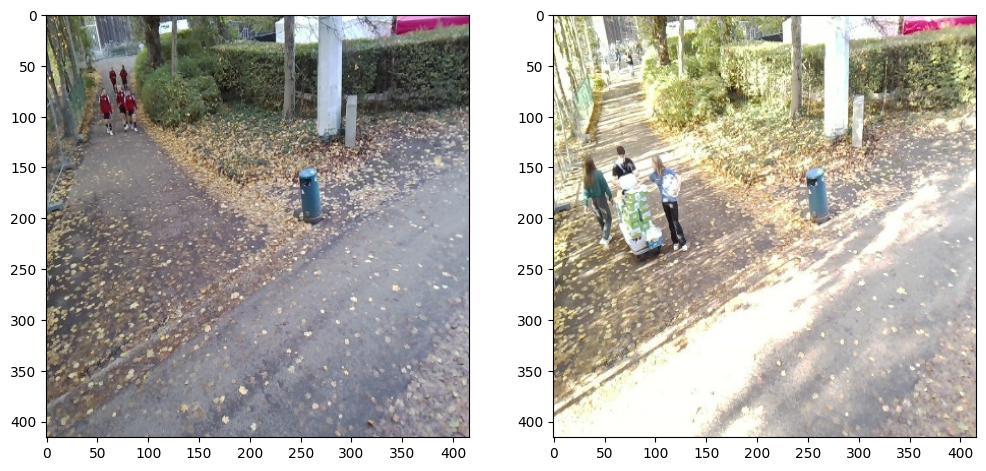

In [5]:
classes = open('coco.names').read().strip().split('\n')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
ax[0].imshow(images[6700])
ax[1].imshow(images[6505])

In [6]:
colors = np.random.randint(0, 255, size=(len(classes), 3), dtype='uint8') # Colors for our classes
net = cv.dnn.readNetFromDarknet('YOLO/yolov3.cfg', 'YOLO/yolov3.weights')
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)

In [7]:
blob = cv.dnn.blobFromImage(images[6505], 1/255.0, (416, 416), crop=False)
blob.shape

(1, 3, 416, 416)

In [8]:
ln = net.getLayerNames()
outNames = net.getUnconnectedOutLayersNames()


net.setInput(blob)
t0 = time.time()
outputs = net.forward(outNames)
t = time.time()
t - 10

1674224541.131876

In [9]:
outputs = np.vstack(outputs)

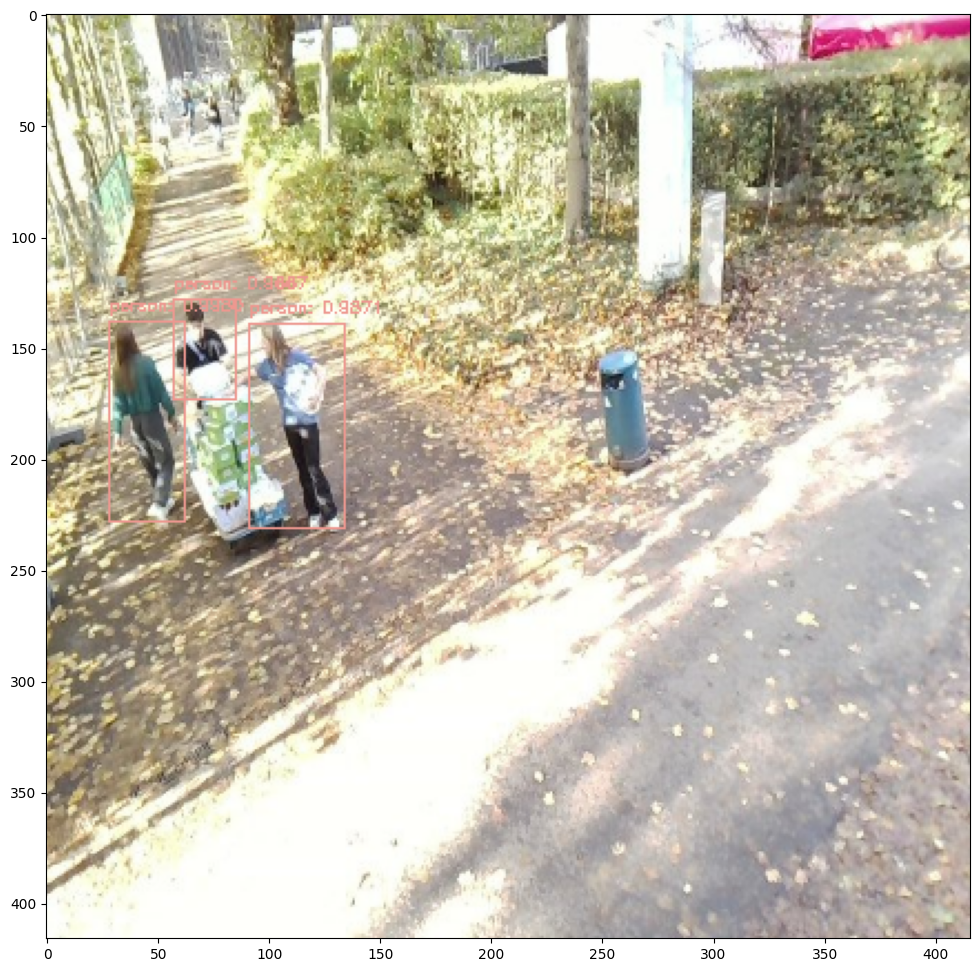

In [10]:
proximus = images[6505].copy()
boxes = []
confidences = []
classIDs = []
confTreshHold = 0.5
h, w = proximus.shape[:2]


for output in outputs:
        scores = output[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        if confidence > confTreshHold:
            box = output[:4] * np.array([w, h, w, h])
            (centerX, centerY, width, height) = box.astype("int")
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            box = [x, y, int(width), int(height)]
            boxes.append(box)
            confidences.append(float(confidence))
            classIDs.append(classID)

indices = cv.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
if len(indices) > 0:
    for i in indices.flatten():
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        color = [int(c) for c in colors[classIDs[i]]]
        cv.rectangle(proximus, (x, y), (x + w, y + h), color, 1)
        text = "{}: {:.4f}".format(classes[classIDs[i]], confidences[i])
        cv.putText(proximus, text, (x, y - 5), cv.FONT_HERSHEY_SIMPLEX, 0.25, color, 1)


fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(proximus)

## Medium task

### Detailed comparison of fine-tuning versus from scratch (performance)

#### Fine-tuning

In [76]:
img_height = 416
img_width = 416
batch_size = 512

In [42]:
base_model = tf.keras.applications.Xception(weights="imagenet", include_top=False, input_shape=(img_height,img_width,3), pooling="max")

base_model.trainable = False

fine_tuning = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1),
    base_model,
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [43]:
fine_tuning.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

fine_tuning.build(input_shape=(None, img_height, img_width, 3))

fine_tuning.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 416, 416, 3)       0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_3 (Dense)             (None, 128)               262272    
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dense_5 (Dense)             (None, 5)                 165       
                                                                 
Total params: 21,128,045
Trainable params: 266,565
Non-trainable params: 20,861,480
_________________________________________________________________


In [71]:
np_df = np.array(images)

In [75]:
fine_tuning.fit(
    x = np_df,
    y = df['choice'],
    epochs=10,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=3)
)

ValueError: Data cardinality is ambiguous:
  x sizes: 7700
  y sizes: 6841
Make sure all arrays contain the same number of samples.